<table style="width: 100%; border: none;">
  <tr style="border: none;">
    <td style="width: 15%; border: none; vertical-align: middle;">
      <img src="https://th.bing.com/th/id/OIP.zZshkvEYWRVv1orlaBMmjwHaHa?w=155&h=180&c=7&r=0&o=5&pid=1.7" alt="Logo UNALM" style="width: 100px;">
    </td>
    <td style="width: 85%; border: none; vertical-align: middle; text-align: left;">
      <h2 style="margin: 0; color: #1a4d2e;">UNIVERSIDAD NACIONAL AGRARIA LA MOLINA</h2>
      <h4 style="margin: 2px 0; color: #444;">FACULTAD DE ECONOMÍA Y PLANIFICACIÓN</h4>
      <h5 style="margin: 0; color: #666; font-weight: normal;">DEPARTAMENTO DE ESTADÍSTICA E INFORMÁTICA</h5>
    </td>
  </tr>
</table>

<hr style="border-top: 2px solid #1a4d2e; margin: 10px 0;">

<div style="padding: 10px;">
  <p style="font-size: 16px; margin: 5px 0;">
    <strong>Curso:</strong> LENGUAJE DE PROGRAMACIÓN II <br>
    <strong>Docente:</strong> Denisse Chalan
  </p>

  <h4 style="margin-top: 15px; color: #1a4d2e;">Integrantes:</h4>
  <ul style="line-height: 1.6;">
    <li>Ormeño Sakihama, Daniel Kenyi - (20240723)</li>
    <li>Garay Ramos, Jose Luis - (20230678)</li>
    <li>Lazaro Medina Pamela Stacey - (20221401)</li>
    <li>Montes Yato, Mónica Fátima - (20220510)</li>
    <li>Terreros Mosquera, Wellington Ricardo - (20241404)</li>
  </ul>
</div>

## **1. Introducción a la API de Datos Abiertos del Banco Mundial**

La herramienta seleccionada para la extracción de datos en este proyecto es la **API (Interfaz de Programación de Aplicaciones) de Indicadores del Banco Mundial** (*World Bank Open Data API*).

Esta interfaz es fundamental para el análisis debido a sus características principales:

* **Robustez y Confiabilidad:** Es considerada una de las fuentes más sólidas a nivel global.
* **Accesibilidad:** Provee acceso programático directo a bases de datos oficiales.
* **Cobertura Multidisciplinaria:** Permite la obtención de información estadística vital sobre **desarrollo económico, demografía, salud y medio ambiente**.

## **2. Análisis descriptivo de Datos (API Banco Mundial)**

En esta etapa, utilizaremos **Python** para extraer información actualizada directamente de los servidores del Banco Mundial.

**Objetivo del Script:**
El propósito de este bloque de código no es solo visualizar una tabla, sino **construir y estructurar el conjunto de datos (DataFrame)** que servirá como base para la **generación de gráficos estadísticos** en la siguiente sección.

**El proceso consta de:**
1.  **Conexión:** Petición de datos macroeconómicos (PBI, Inflación, Gini, etc.) para 12 países de Sudamérica.
2.  **Limpieza:** Filtrado del año más reciente disponible (entre 2019-2024) para garantizar la actualidad del análisis.
3.  **Previsualización:** Muestra de un resumen tabular estilizado para validar que los datos se han cargado correctamente antes de graficar.

In [5]:
# CONFIGURACIÓN DEL ENTORNO Y LIBRERÍAS (SETUP DEFINITIVO)

# --- 1. Procesamiento de Datos ---
import pandas as pd
import numpy as np

# --- 2. Conexión Web, APIs y Scraping ---
import requests                     # Para hacer peticiones HTTP (GET)
import json                         # Para manejar respuestas de APIs
from bs4 import BeautifulSoup       # Para Web Scraping (Parsear HTML)

# --- 3. Visualización Gráfica ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4. Análisis Estadístico y Econometría ---
from scipy.stats import jarque_bera             # Test de Normalidad
from statsmodels.stats.stattools import durbin_watson # Test de Autocorrelación
from statsmodels.graphics.gofplots import qqplot      # Gráfico Q-Q

# --- 5. Configuración de Estilo Global ---
sns.set_theme(style="whitegrid")          # Fondo limpio
plt.rcParams['figure.figsize'] = (12, 6)  # Gráficos anchos
plt.rcParams['font.size'] = 11            # Letra legible

print("Entorno 100% cargado: APIs, Scraping, Estadística y Gráficos listos.")

Entorno 100% cargado: APIs, Scraping, Estadística y Gráficos listos.


In [6]:
# ==============================================================================
# PASO 1: DESCARGA REAL DESDE LA API (ETL)
# ==============================================================================
print("Conectando al Banco Mundial...", end="")

paises_sudamerica = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']
codigos_paises = ';'.join(paises_sudamerica)

indicadores = {
    'NY.GDP.MKTP.CD': 'PBI_Raw',
    'SP.POP.TOTL':    'Poblacion_Raw',
    'SI.POV.NAHC':    'Pobreza_Nacional',
    'FP.CPI.TOTL.ZG': 'Inflacion_Anual',
    'SI.POV.GINI':    'Indice_Gini'
}

def descargar_wb(indicador, paises):
    # Pedimos datos desde 2015 para asegurar que si no hay dato 2024, tome el de 2023 o 2022
    url = f"http://api.worldbank.org/v2/country/{paises}/indicator/{indicador}?format=json&date=2015:2024&per_page=1000"
    try:
        data = requests.get(url).json()
        if len(data) < 2: return []
        lista = []
        for item in data[1]:
            if item['value'] is not None:
                lista.append({
                    'Codigo_ISO': item['countryiso3code'],
                    'País': item['country']['value'],
                    'Año': item['date'],
                    'Valor': item['value']
                })
        return lista
    except:
        return []

dfs = []
for codigo_api, nombre_interno in indicadores.items():
    datos = descargar_wb(codigo_api, codigos_paises)
    if datos:
        temp = pd.DataFrame(datos)
        temp = temp.sort_values('Año', ascending=False).drop_duplicates('Codigo_ISO')
        temp = temp[['País', 'Valor']].rename(columns={'Valor': nombre_interno})
        temp = temp.set_index('País')
        dfs.append(temp)
    print(".", end="")

# Unimos todo en un solo DataFrame
if dfs:
    df = pd.concat(dfs, axis=1)

    # --- TRANSFORMACIÓN DE UNIDADES (Para que coincida con tus gráficos) ---
    # Tus gráficos piden 'PBI_Billions' y 'Poblacion_Millones'
    if 'PBI_Raw' in df.columns:
        df['PBI_Billions'] = df['PBI_Raw'] / 1e9  # Convertimos a Miles de Millones

    if 'Poblacion_Raw' in df.columns:
        df['Poblacion_Millones'] = df['Poblacion_Raw'] / 1e6 # Convertimos a Millones

    print("\n Datos descargados y procesados correctamente.\n")
    # Mostramos las primeras filas para verificar
    display(df.head(3))
else:
    print("\n Error crítico: La API no devolvió datos. Revisa tu conexión.")

Conectando al Banco Mundial........
 Datos descargados y procesados correctamente.



,PBI_Raw,Poblacion_Raw,Pobreza_Nacional,Inflacion_Anual,Indice_Gini,PBI_Billions,Poblacion_Millones
País,,,,,,,
Argentina,6.383655e+11,45696159,38.1,219.883929,42.4,638.365455,45.696159
Brazil,2.185822e+12,211998573,NaN,4.367464,51.6,2185.821649,211.998573
"Venezuela, RB",1.198030e+11,28405543,33.1,254.948535,NaN,119.802963,28.405543


### 2.1 Mapa de Calor: El "Termómetro" de la Inflación

Este gráfico funciona como una alerta visual para identificar la estabilidad monetaria en la región.
* **Colores Rojos Intensos:** Indican economías con **alta inflación**. En estos países, los precios suben rápidamente, lo que erosiona el poder adquisitivo de las personas.
* **Colores Claros:** Indican **estabilidad**. El dinero mantiene su valor en el tiempo.

**Conclusión:** Podemos identificar rápidamente los focos de riesgo económico en Sudamérica y contrastarlos con los países que mantienen políticas monetarias estables.

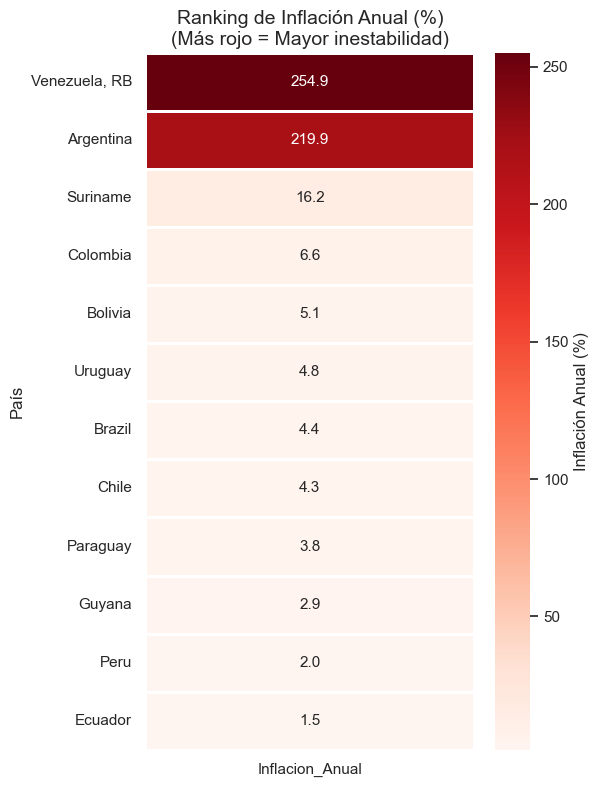

In [8]:

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


if 'País' in df.columns:
    df = df.set_index('País')

# Filtramos y ordenamos
if 'Inflacion_Anual' in df.columns:
    df_inflacion = df[['Inflacion_Anual']].sort_values(by='Inflacion_Anual', ascending=False)

    plt.figure(figsize=(6, 8))

    sns.heatmap(df_inflacion,
                annot=True,            # Muestra el número
                cmap='Reds',           # Rojo = Peligro
                fmt=".1f",             # 1 decimal
                cbar_kws={'label': 'Inflación Anual (%)'},
                linewidths=1, linecolor='white') # Bordes para limpieza visual

    plt.title('Ranking de Inflación Anual (%)\n(Más rojo = Mayor inestabilidad)', fontsize=14)
    plt.tight_layout()
    plt.show()

### 2.2 Desigualdad Social (Índice Gini)

El PBI nos dice cuánto dinero tiene un país, pero el **Índice Gini** nos dice cómo se reparte ese dinero.
* **Barras más largas (Cercanas a 100):** Indican mayor desigualdad. La brecha entre ricos y pobres es muy amplia.
* **Barras más cortas (Cercanas a 0):** Indican una distribución de riqueza más equitativa.

**Análisis:** Este ranking nos permite ver qué países, independientemente de su riqueza total, han logrado construir sociedades más justas en términos económicos.

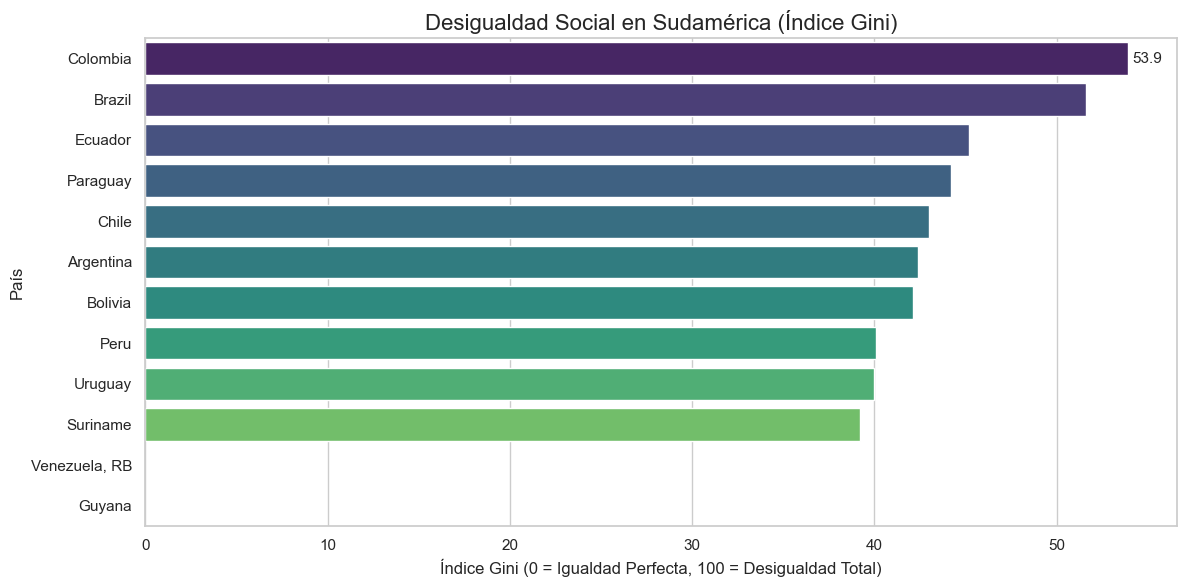

In [10]:

if 'Indice_Gini' in df.columns:
    # Ordenamos de mayor a menor desigualdad
    df_gini = df.sort_values('Indice_Gini', ascending=False)

    plt.figure(figsize=(12, 6))
    grafico = sns.barplot(
        x=df_gini['Indice_Gini'],
        y=df_gini.index,
        hue=df_gini.index,     # Asignamos el color al País
        palette='viridis',
        legend=False           # Ocultamos la leyenda
    )

    plt.title('Desigualdad Social en Sudamérica (Índice Gini)', fontsize=16)
    plt.xlabel('Índice Gini (0 = Igualdad Perfecta, 100 = Desigualdad Total)')

    # Agregamos los valores al final de las barras
    plt.bar_label(grafico.containers[0], fmt='%.1f', padding=3)

    plt.tight_layout()
    plt.show()

### 2.3 Correlación: Inflación vs. Pobreza

Este gráfico de dispersión busca responder: **¿La subida de precios genera más pobreza?**
Dividimos el gráfico en cuadrantes usando el promedio regional (líneas punteadas):
1.  **Cuadrante Superior Derecho:** Países con el "doble castigo" (Alta Inflación y Alta Pobreza). Son los casos más críticos.
2.  **Cuadrante Inferior Izquierdo:** El escenario ideal (Baja Inflación y Baja Pobreza).

**Interpretación:** La ubicación de los puntos nos ayuda a entender si la inestabilidad de precios está golpeando a los sectores más vulnerables de cada país.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


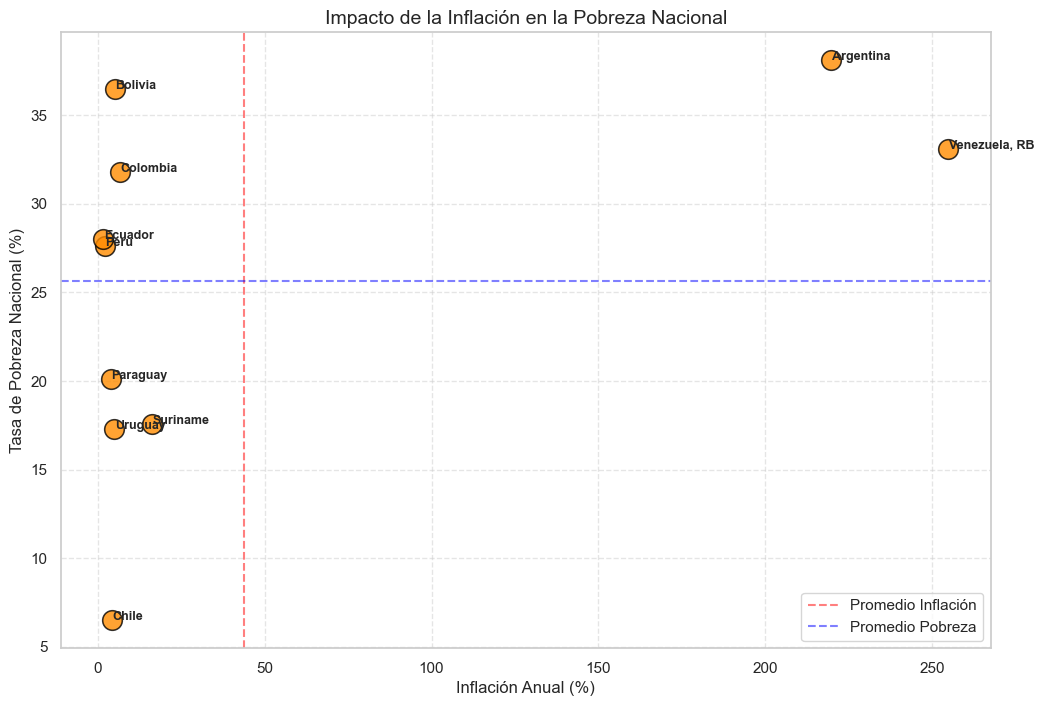

In [12]:
if 'Inflacion_Anual' in df.columns and 'Pobreza_Nacional' in df.columns:
    plt.figure(figsize=(12, 8))

    # Gráfico de dispersión
    sns.scatterplot(data=df, x='Inflacion_Anual', y='Pobreza_Nacional',
                    s=200, color='darkorange', alpha=0.8, edgecolor='black')

    # Nombres de los países
    for pais in df.index:
        plt.text(df.loc[pais, 'Inflacion_Anual']+0.2,
                 df.loc[pais, 'Pobreza_Nacional'],
                 pais, fontsize=9, fontweight='bold')

    # Líneas promedio (Cuadrantes)
    plt.axvline(x=df['Inflacion_Anual'].mean(), color='red', linestyle='--', alpha=0.5, label='Promedio Inflación')
    plt.axhline(y=df['Pobreza_Nacional'].mean(), color='blue', linestyle='--', alpha=0.5, label='Promedio Pobreza')
    plt.legend()

    plt.title('Impacto de la Inflación en la Pobreza Nacional', fontsize=14)
    plt.xlabel('Inflación Anual (%)')
    plt.ylabel('Tasa de Pobreza Nacional (%)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### 2.4 Riqueza Promedio por Habitante (PBI Per Cápita)

Este indicador elimina el "efecto tamaño". Brasil tiene una economía gigante porque tiene mucha población, pero eso no significa que el ciudadano promedio sea rico.
* **El cálculo:** Dividimos el PBI Total entre la Población Total.
* **El resultado:** Obtenemos una aproximación del ingreso promedio anual por persona en dólares.

**Conclusión:** Este ranking refleja mejor la **calidad de vida y poder de consumo** promedio. Vemos cómo países pequeños pueden superar a economías grandes cuando ajustamos por población.

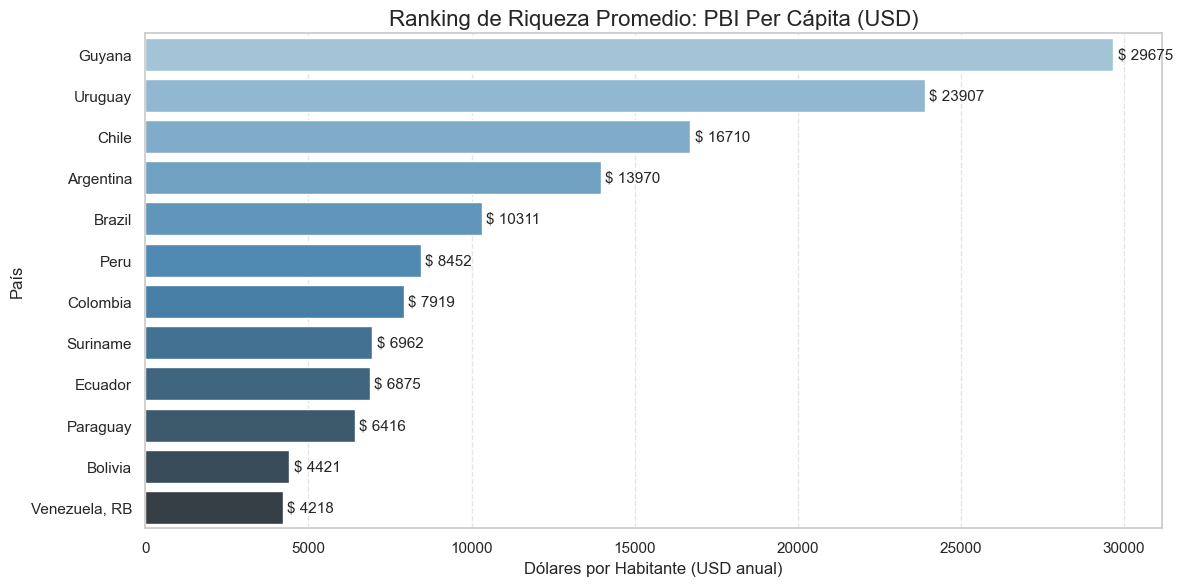

In [14]:

if 'PBI_Billions' in df.columns and 'Poblacion_Millones' in df.columns:
    # 1. Cálculos
    df['PBI_Per_Capita'] = (df['PBI_Billions'] / df['Poblacion_Millones']) * 1000
    df_per_capita = df.sort_values('PBI_Per_Capita', ascending=False)

    plt.figure(figsize=(12, 6))
    grafico = sns.barplot(
        x=df_per_capita['PBI_Per_Capita'],
        y=df_per_capita.index,
        hue=df_per_capita.index,  # Asignamos el color al País
        palette='Blues_d',
        legend=False              # Ocultamos la leyenda porque ya tenemos etiquetas en el eje Y
    )

    plt.title('Ranking de Riqueza Promedio: PBI Per Cápita (USD)', fontsize=16)
    plt.xlabel('Dólares por Habitante (USD anual)', fontsize=12)

    # Etiquetas de datos ($)
    for i, container in enumerate(grafico.containers):
        grafico.bar_label(container, fmt='$ %.0f', padding=3)

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 2.5 Evolución del PBI del Perú y Predicción Económica

A diferencia del análisis comparativo regional presentado anteriormente, en esta sección se realiza un análisis específico del **Producto Bruto Interno (PBI) real del Perú**, utilizando datos oficiales obtenidos a través de la **API Data360 del Banco Mundial**.

* **Enfoque:** Análisis temporal del crecimiento económico del Perú.
* **Fuente de datos:** API Data360 – Banco Mundial.
* **Metodología:** Limpieza de datos, visualización y modelamiento estadístico.

**Interpretación:**  
La evolución histórica del PBI muestra una tendencia de crecimiento a largo plazo, con periodos de desaceleración y recuperación económica asociados a eventos coyunturales relevantes.

**Predicción:**  
Mediante el uso de regresión polinómica, se realiza una estimación del PBI para el año 2025 con fines estrictamente académicos.

**Conclusión:**  
Este análisis permite complementar el estudio regional incorporando un caso nacional específico, demostrando la aplicación de técnicas de programación y análisis estadístico para el estudio del crecimiento económico.



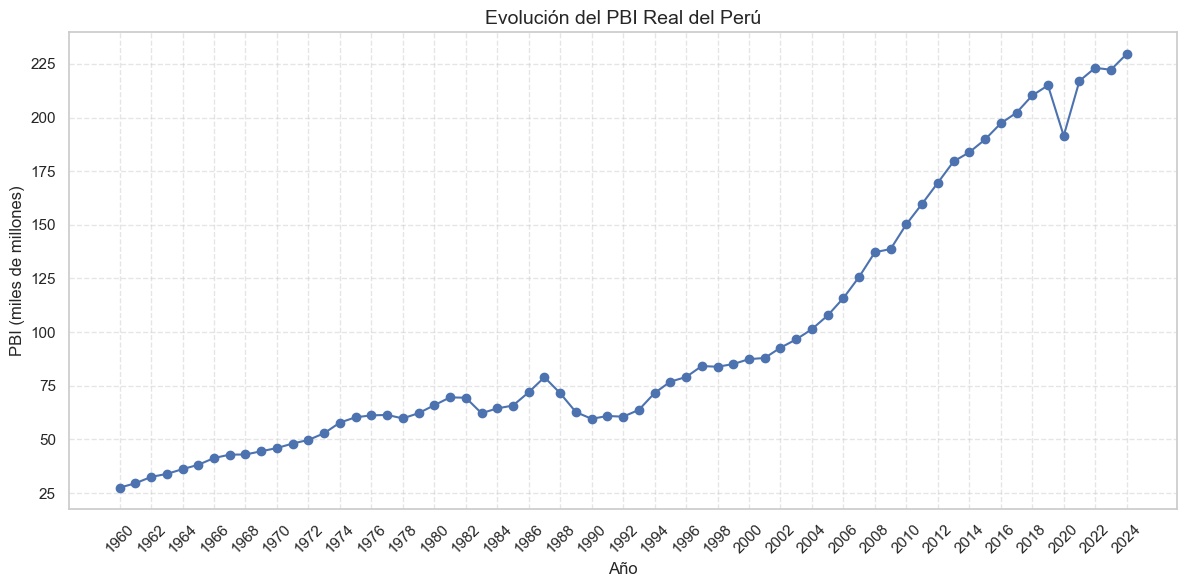

In [16]:
url = "https://data360api.worldbank.org/data360/data"

parametros = {
    "DATABASE_ID": "WB_WDI",
    "REF_AREA": "PER",
    "INDICATOR": "WB_WDI_NY_GDP_MKTP_KD"
}

response = requests.get(url, params=parametros)
json_data = response.json()

df_pbi = pd.DataFrame(json_data['value'])
df_pbi['OBS_VALUE'] = pd.to_numeric(df_pbi['OBS_VALUE'], errors='coerce')
df_pbi = df_pbi.dropna(subset=['OBS_VALUE'])

# Convertimos a miles de millones
df_pbi['PBI_miles_millones'] = df_pbi['OBS_VALUE'] / 1e9

plt.figure(figsize=(12, 6))

plt.plot(
    df_pbi['TIME_PERIOD'],
    df_pbi['PBI_miles_millones'],
    marker='o'
)

plt.title('Evolución del PBI Real del Perú', fontsize=14)
plt.xlabel('Año')
plt.ylabel('PBI (miles de millones)')
plt.grid(True, linestyle='--', alpha=0.5)

# 🔹 MOSTRAR ETIQUETAS CADA 2 AÑOS
plt.xticks(
    ticks=df_pbi['TIME_PERIOD'][::2],
    rotation=45
)

plt.tight_layout()
plt.show()


### 2.6 Análisis Comparativo Regional

Para contextualizar la situación de Perú, es necesario realizar un análisis comparativo con otras economías de la región (Latinoamérica). En esta sección utilizaremos la API del Banco Mundial para responder tres preguntas clave mediante visualización de datos:

1.  **Ranking (2022):** ¿Qué posición ocupa Perú en términos de tamaño de economía frente a sus vecinos?
2.  **Volatilidad (2010-2023):** ¿Qué tan estable ha sido el crecimiento económico comparado con la Alianza del Pacífico?
3.  **Correlación:** ¿Existe una relación directa entre la riqueza de un país (PBI) y la calidad de vida (Esperanza de Vida)?

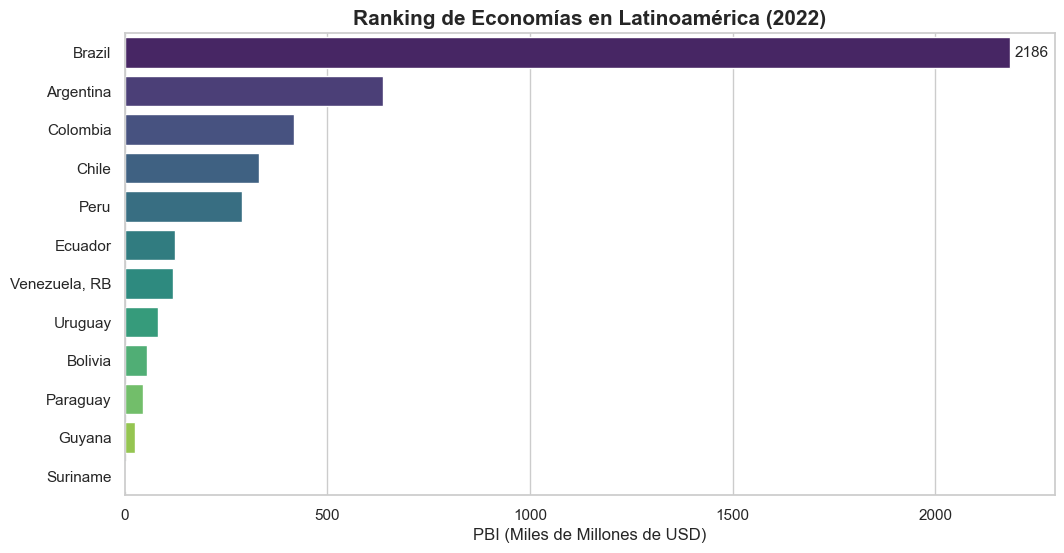

In [18]:

# 1. Resetear el índice para que 'País' se convierta en una columna
df_ranking = df.reset_index()

# 2. Renombrar la columna 'PBI_Billions' a 'PBI (Billones USD)'
if 'PBI_Billions' in df_ranking.columns:
    df_ranking = df_ranking.rename(columns={'PBI_Billions': 'PBI (Billones USD)'})

# 3. Ordenar los datos de mayor a menor PBI para que el gráfico salga ordenado
df_ranking = df_ranking.sort_values('PBI (Billones USD)', ascending=False)

plt.figure(figsize=(12, 6))
grafico = sns.barplot(
    data=df_ranking, 
    x='PBI (Billones USD)', 
    y='País', 
    hue='País',       
    palette='viridis', 
    legend=False      
)

plt.title('Ranking de Economías en Latinoamérica (2022)', fontsize=15, fontweight='bold')
plt.xlabel('PBI (Miles de Millones de USD)')
plt.ylabel('')
plt.bar_label(grafico.containers[0], fmt='%.0f', padding=3) 

plt.show()

## **3. Análisis predictivos API Data Mundial**

Se estima un modelo de regresión lineal múltiple mediante Mínimos Cuadrados Ordinarios (OLS)
para analizar la relación entre la pobreza nacional y variables macroeconómicas seleccionadas.

### 3.1 Preparación del data set para la regresion

In [33]:
# Copia de trabajo
datos_sudamerica = df.copy()

# PBI per cápita (en dólares)
datos_sudamerica['PBI_Per_Capita'] = (
    datos_sudamerica['PBI_Raw'] / datos_sudamerica['Poblacion_Raw']
)

# Seleccionar variables del modelo
variables_modelo = [
    'Pobreza_Nacional',
    'Inflacion_Anual',
    'Indice_Gini',
    'PBI_Per_Capita'
]

# Eliminar filas con valores faltantes
datos_sudamerica = datos_sudamerica[variables_modelo].dropna()

# Verificar dataset final
display(datos_sudamerica)

,Pobreza_Nacional,Inflacion_Anual,Indice_Gini,PBI_Per_Capita
País,,,,
Argentina,38.1,219.883929,42.4,13969.783660
Uruguay,17.3,4.849144,40.0,23906.513303
Suriname,17.6,16.229616,39.2,6961.789560
Paraguay,20.1,3.835403,44.2,6416.097090
Peru,27.6,2.007707,40.1,8452.371671
Ecuador,28.0,1.547325,45.2,6874.705740
Colombia,31.8,6.609086,53.9,7919.208868
Chile,6.5,4.297639,43.0,16709.889397
Bolivia,36.5,5.099766,42.1,4421.166099


### 3.2 Estimación del modelo de regresion

In [42]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", message="kurtosistest only valid for n>=20")

# Variable dependiente
y = datos_sudamerica['Pobreza_Nacional']

# Variables independientes
X = datos_sudamerica[
    ['Inflacion_Anual', 'Indice_Gini', 'PBI_Per_Capita']
]

# Agregar constante
X = sm.add_constant(X)

# Ajustar modelo
modelo = sm.OLS(y, X).fit()

# Resumen
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:       Pobreza_Nacional   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     2.064
Date:                Fri, 19 Dec 2025   Prob (F-statistic):              0.224
Time:                        10:14:48   Log-Likelihood:                -29.589
No. Observations:                   9   AIC:                             67.18
Df Residuals:                       5   BIC:                             67.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.0879     33.142     

### Interpretación de los coeficientes del modelo de regresión lineal

El modelo de regresión lineal estimado tiene como variable dependiente el porcentaje de población en situación de pobreza a nivel nacional (*Pobreza_Nacional*), utilizando como variables explicativas la inflación anual, el índice de Gini y el PBI per cápita. La muestra está conformada por nueve países de América del Sur.

#### Término constante (const)

El coeficiente estimado del término constante es **11.09**. Este valor representa el nivel promedio de pobreza nacional cuando todas las variables explicativas toman el valor cero. Si bien esta situación no tiene una interpretación económica directa (ya que inflación, desigualdad e ingreso no pueden ser cero en la práctica), el término constante permite ajustar correctamente el modelo.

#### Inflación anual (*Inflacion_Anual*)

El coeficiente asociado a la inflación anual es **0.0842**. Esto indica que, manteniendo constantes el índice de Gini y el PBI per cápita, un incremento de **1 punto porcentual en la inflación anual** se asocia con un aumento promedio de **0.084 puntos porcentuales en la tasa de pobreza nacional**. Este resultado sugiere que mayores niveles de inflación tienden a deteriorar el poder adquisitivo de la población, incrementando la pobreza. No obstante, el coeficiente no resulta estadísticamente significativo al nivel del 5%, lo cual puede estar relacionado con el reducido tamaño muestral.

#### Índice de Gini (*Indice_Gini*)

El coeficiente estimado para el índice de Gini es **0.4598**. Esto implica que, ceteris paribus, un aumento de **1 punto en el índice de Gini** se asocia con un incremento promedio de **0.46 puntos porcentuales en la pobreza nacional**. El signo positivo es consistente con la teoría económica, ya que una mayor desigualdad en la distribución del ingreso suele estar vinculada a mayores niveles de pobreza. Sin embargo, este coeficiente tampoco es estadísticamente significativo, lo cual sugiere cautela en su interpretación.

#### PBI per cápita (*PBI_Per_Capita*)

El coeficiente del PBI per cápita es **-0.0008**. Este valor indica que, manteniendo constantes la inflación y la desigualdad, un incremento de **1 dólar en el PBI per cápita** se asocia con una reducción promedio de **0.0008 puntos porcentuales en la pobreza nacional**. Aunque el efecto individual es pequeño debido a la escala de la variable, el signo negativo concuerda con la teoría económica, ya que mayores niveles de ingreso promedio tienden a reducir la pobreza. Al igual que los demás coeficientes, este efecto no resulta estadísticamente significativo al 5%.

#### Consideraciones generales del modelo

El coeficiente de determinación (**R² = 0.553**) indica que aproximadamente el **55.3% de la variabilidad observada en la pobreza nacional** es explicada por las variables incluidas en el modelo. No obstante, el reducido tamaño de la muestra (n = 9 países) limita la potencia esta


### 3.3 Evaluación de supuestos del modelo de regresión

En esta sección se verifican los principales supuestos del modelo de regresión
lineal estimado previamente. Estos supuestos permiten evaluar si los resultados
del modelo son confiables y correctamente interpretables.

In [44]:
# =====================================================
# Cálculo de los indicadores de los supuestos
# =====================================================

# Normalidad de los errores (Jarque-Bera)
jb_stat, jb_pvalue = jarque_bera(modelo.resid)

# Independencia de errores (Durbin-Watson)
dw = durbin_watson(modelo.resid)

# Multicolinealidad (Número de condición)
cond_number = modelo.condition_number

# Homocedasticidad (relación entre errores y valores ajustados)
corr_resid_fitted = np.corrcoef(
    modelo.fittedvalues,
    np.abs(modelo.resid)
)[0, 1]

### 3.4 Indicadores utilizados

- **Jarque-Bera:** evalúa si los errores del modelo siguen una distribución normal.
- **Durbin-Watson:** permite detectar autocorrelación entre los errores.
- **Número de condición:** indica si existe multicolinealidad entre las variables explicativas.
- **Correlación residuos-ajustados:** ayuda a evaluar la estabilidad de la varianza
  de los errores (homocedasticidad).

In [46]:
# =====================================================
# Tabla resumen de supuestos del modelo
# =====================================================

tabla_supuestos = pd.DataFrame({
    "Supuesto": [
        "Normalidad de los errores",
        "Independencia de los errores",
        "Homocedasticidad",
        "Multicolinealidad"
    ],
    "Indicador": [
        "Jarque-Bera (p-valor)",
        "Durbin-Watson",
        "Corr(|residuos|, ajustados)",
        "Número de condición"
    ],
    "Valor": [
        round(jb_pvalue, 3),
        round(dw, 3),
        round(corr_resid_fitted, 3),
        f"{cond_number:.2e}"
    ],
    "Conclusión": [
        "Se cumple" if jb_pvalue > 0.05 else "No se cumple",
        "Se cumple" if 1.5 < dw < 2.5 else "Posible problema",
        "Se cumple" if abs(corr_resid_fitted) < 0.3 else "Posible heterocedasticidad",
        "Posible problema" if cond_number > 30 else "Sin problema"
    ]
})

tabla_supuestos

,Supuesto,Indicador,Valor,Conclusión
0,Normalidad de los errores,Jarque-Bera (p-valor),0.73,Se cumple
1,Independencia de los errores,Durbin-Watson,2.535,Posible problema
2,Homocedasticidad,"Corr(|residuos|, ajustados)",-0.625,Posible heterocedasticidad
3,Multicolinealidad,Número de condición,1.39e+05,Posible problema


### 3.5 Interpretación de los supuestos

La tabla anterior resume la evaluación de los supuestos del modelo.  
En general:

- Un **p-valor mayor a 0.05** en Jarque-Bera indica normalidad de los errores.
- Un **Durbin-Watson cercano a 2** sugiere independencia de los errores.
- Una **correlación pequeña** entre errores y valores ajustados indica homocedasticidad.
- Un **número de condición bajo** sugiere ausencia de multicolinealidad severa.

### 3.6 Gráficos de diagnóstico

<Figure size 1000x600 with 0 Axes>

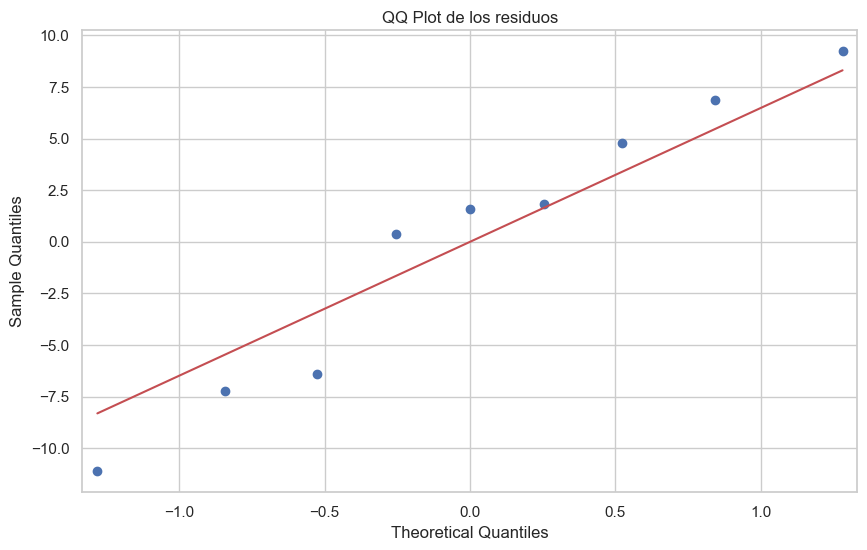

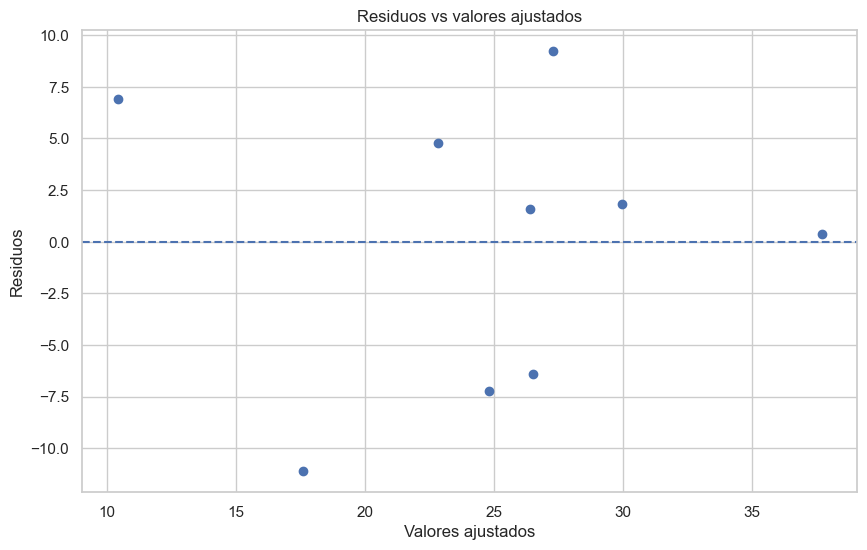

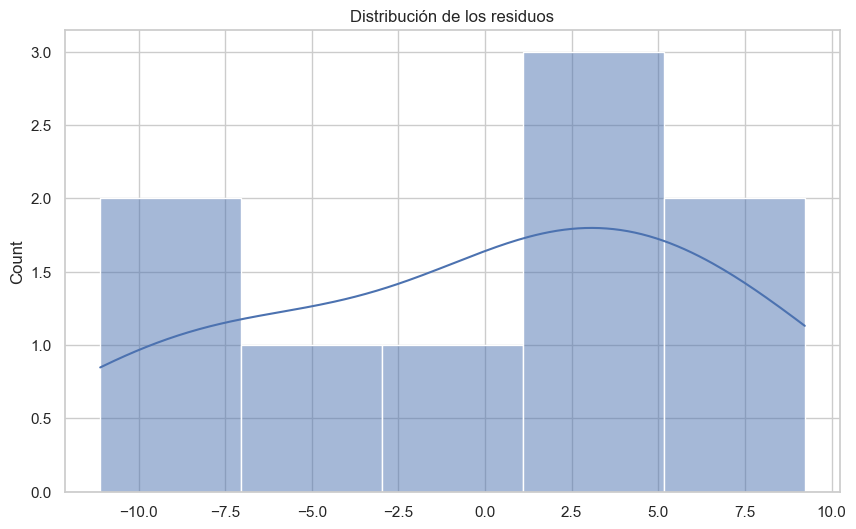

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

sns.set_style("whitegrid")

# QQ Plot - Normalidad
plt.figure()
qqplot(modelo.resid, line='s')
plt.title("QQ Plot de los residuos")
plt.show()

# Residuos vs Ajustados - Homocedasticidad
plt.figure()
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(0, linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs valores ajustados")
plt.show()

# Histograma de residuos
plt.figure()
sns.histplot(modelo.resid, kde=True)
plt.title("Distribución de los residuos")
plt.show()


### 3.7 Análisis gráfico de los supuestos

- El **QQ Plot** permite evaluar visualmente la normalidad de los errores.
- El gráfico de **residuos vs valores ajustados** permite detectar posibles
  problemas de heterocedasticidad.
- El **histograma de residuos** muestra la forma general de la distribución
  de los errores del modelo.


### 3.8 Verificación de los tipos de datos

Antes de realizar la predicción, se verifica que todas las variables utilizadas
en el modelo tengan un tipo de dato numérico, ya que los modelos de regresión
lineal solo admiten variables cuantitativas.

In [ ]:
# =====================================================
# Tipos de datos de las variables del modelo
# =====================================================
print("Tipos de datos del DataFrame original:\n")
display(df_reg.dtypes)

print("\nTipos de datos del conjunto de predicción:\n")
display(nuevo_pais.dtypes)

### 3.9 Predicción del modelo

En esta sección se utiliza el modelo estimado para predecir el nivel de pobreza
nacional a partir de valores específicos de inflación, desigualdad (Índice de Gini)
y PBI per cápita.

In [50]:
# =====================================================
# Predicción de la pobreza nacional
# =====================================================
nuevo_pais = pd.DataFrame({
    "const": [1],
    "Inflacion_Anual": [6.5],
    "Indice_Gini": [0.45],
    "PBI_Per_Capita": [12000]
})
prediccion = modelo.predict(nuevo_pais)
prediccion

0    2.064337
dtype: float64

Este valor representa el porcentaje estimado de la población que se
encontraría en situación de pobreza bajo las condiciones económicas
especificadas. Es decir, de cada 100 personas, alrededor de 2 personas
vivirían en situación de pobreza.

## PARTE DE LUIS

## **Extracción y Limpieza (Fase de Preprocesamiento de datos)**

Hemos decidido como grupo bajar información de la API del Banco Mundial, dado que los datos de esa fuente siempre se actualiza.
Nos hemos ayudado de ***requests*** para filtrar específicamente el **PBI** del Perú 

In [ ]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 
import statsmodels.formula.api as smf 
import statsmodels.formula.api as qqplot
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [ ]:
url = "https://data360api.worldbank.org/data360/data"
# indicador del PBI en el perú
parametros = {
            "DATABASE_ID": "WB_WDI",
            "REF_AREA": "PER",
            "INDICATOR": "WB_WDI_NY_GDP_MKTP_KD"
        }
response = requests.get(url, params=parametros)
json_data = response.json()
df = pd.DataFrame(json_data['value'])
cols = ['TIME_PERIOD', 'OBS_VALUE']
df_limpio = df[cols].copy()

In [ ]:
#print(df_limpio.info())
# convertimos los datos a otro tipo de dato para analizarla
# veremos antes si existe valores nulos
print(df_limpio.isnull().sum())
# no hay valores nulos en caso halla usar drop.na()

In [ ]:
# cambiamos el tipo de dato
df_limpio['TIME_PERIOD'] = df_limpio['TIME_PERIOD'].astype(int)
df_limpio['OBS_VALUE'] = pd.to_numeric(df_limpio['OBS_VALUE'], errors= 'coerce') # si tiene nulos colocará NaN
#print(df_limpio.info())
y = df_limpio['OBS_VALUE']
x = df_limpio['TIME_PERIOD']

## **Análisis Descriptivo**

Como las dos variables son de tipo cuantitativa, le aplicaremos grafico de dispersión 

In [ ]:
sns.scatterplot(x=x,y=y,data = df_limpio)

In [ ]:
Observamos PBI con curva y como que quiere formarse una S

In [ ]:
# grafico lineal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
sns.regplot(x='TIME_PERIOD', y='OBS_VALUE', data=df_limpio,
                    ax=ax1,
                    order=1,
                    line_kws={'color': 'red'},
                    scatter_kws={'alpha': 0.5})
ax1.set_title('Modelo Lineal', fontsize=14)
ax1.set_ylabel('PIB')

In [ ]:
#linea de regresion de grado 3
sns.regplot(x='TIME_PERIOD', y='OBS_VALUE', data=df_limpio,
                    ax=ax2,
                    order=3,
                    line_kws={'color': 'green'},
                    scatter_kws={'alpha': 0.5})

ax2.set_title('Modelo Polinómico G3 (R² ≈ 0.98)', fontsize=14)
plt.show()

Con este gráfico, podemos concluir que es mejor modelar estos datos con una regresión polinomial, hacemos una comparación visualmente con la regresión lineal simple, y vemos que si bien sí se ajusta, el modelo polinomial de grado 3 se ajusta mucho mejor, analizaremos ello. 


## R2 (Coeficiente de determinación)

Sabemos que el R2, es una medida de bondad de ajuste, y nos dice que tanto el modelo se ajusta a los datos o que tanto puede explicar a la variable dependiente en este caso el PBI



In [ ]:
#modelo polinomial de grado 3
formula = "OBS_VALUE ~ TIME_PERIOD + I(TIME_PERIOD**2) + I(TIME_PERIOD**3)"
modelo_poli = ols(formula, df_limpio).fit()
print(modelo_poli.summary())


Vemos muchos valores importantes aquí, pero nos centraremos a lo que queremos ir, R2; sin embargo, es importante destacar la prueba de Jarque Bera (usado para evaluar normalidad), se cumple ese supuesto de Jarque Bera con un p.valor de 0.227; otra cosa en analizar es el R2 = 0.959 un valor alto, lo que indica que el modelo ajusta demasiado bien. 

#modelo lineal 

In [ ]:
mod_lineal = ols("OBS_VALUE ~ TIME_PERIOD", data=df_limpio).fit()
print(mod_lineal.summary())

De forma similar vemos que el R2 = 0.843, es un valor alto y bueno, pero en comparación con el otro modelo, el otro gana

In [ ]:
r2_lineal = mod_lineal.rsquared
r2_poly = modelo_poli.rsquared
if r2_poly > r2_lineal:
    print(f"El modelo polinomial explica mejor al PBI con un r2 de {round(r2_poly,2)*100} %")
else:
    print(f"El modelo lineal explica mejor al PBI con un r2 de {round(r2_lineal,2)*100} %")

## **Supuestos**

In [ ]:
sm.qqplot(modelo_poli.resid, fit=True, line='45')

## **Predicciones**

In [ ]:
#Definimos los años futuros que queremos proyectar
años_futuros = [2025, 2026, 2027, 2028, 2029, 2030]

In [ ]:
# Creamos  la misma columna con otros datos
df_proyeccion = pd.DataFrame({'TIME_PERIOD': años_futuros})
print(df_proyeccion)

In [ ]:
predicciones = modelo_poli.predict(df_proyeccion)
predicciones

In [ ]:
#mostramos los resultados en la tabla
resultados = pd.DataFrame({
    'Año': años_futuros,
    'PIB_Estimado': predicciones
})
resultados

In [ ]:
#visualizamos el resultado con los datos que ya teniamos 
plt.figure(figsize=(10, 5))
plt.plot(df_limpio['TIME_PERIOD'], df_limpio['OBS_VALUE'], label='Histórico', marker='o')
plt.plot(resultados['Año'], resultados['PIB_Estimado'], label='Proyección',linestyle='--', marker='s', color='orange')
plt.title('Proyección del PIB de Perú al 2030')
plt.legend()
plt.grid()
plt.show()
